# Working With Text AE1

**Imagine you are working on a data science project for a music agency. Your task is
to develop an application that indexes each song in the agency's catalogue. To
achieve this, you will analyse the frequency of words and sentiment scores of the
song lyrics. Additionally, you are expected to suggest new automatically generated
song lyrics. The application should allow users to specify the names of two artists (or
bands), and it will analyse the frequency of words and sentiment scores for each
artist, produce visualisations of the results, and generate new song lyrics for the
specified artists. The solution you create should be able to handle any artist in the
dataset. If a specific artist is not available in the dataset, the application should
inform the user accordingly.**


## Part 1 - Loading and Pre-Processing Text

**Load and preprocess the text data, converting it to i) lowercase, ii) removing special
characters, iii) digits, and iv) redundant whitespace, v) list of words and vi) excluding
meaningless words.**

In [1]:
# imports
import pandas as pd
import string
import math
from textblob import TextBlob
from pathlib import Path  
import wordcloud as wc   
import imageio          
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.stats import ttest_ind
import random 
from sklearn.linear_model import LinearRegression


In [2]:
# reading in the file using pandas
song_df = pd.read_csv("spotify_millsongdata.csv")

# pre-defined list of stopwords
stopwords = ["a", "an", "the", "i", "im", "he", "she", "they", "and", "if",
             "of", "out", "do", "you", "to", "it", "is", "was", "in", "we",
             "that", "my", "your", "be", "on", "this", "me", "are", "what",
             "with", "but", "youre", "so", "oh", "for", "like", "him",
             "have", "not", "one", "too", "just", "dont", "well", "yeah",
             "all", "let", "about", "go", "can", "at", "hes", "thats", "am",
             "its", "as", "were", ""]

# This function cleans the text that is passed in 
def clean_text(text):
    '''
        Parameters
        ----------
        text : list
            This is a list of words per song passed in from the dataframe one at a time 

        Returns
        -------
        cleaned_words: list
            This is a cleaned list of words without punctuation, digits, or uppercase words

        '''
    # Remove punctuation and digits
    cleaned_text = text.translate(str.maketrans('', '', string.punctuation)).translate(str.maketrans('', '', string.digits))
    # Convert to lowercase and split into words
    words = cleaned_text.lower().split()
    
    # Remove stopwords
    cleaned_words = [word for word in words if word not in stopwords]
    return cleaned_words

# Apply the cleaning function to each row in the "text" column
song_df["cleaned_text"] = song_df["text"].apply(clean_text)
# lowers the artists name column 
song_df["artist"] = song_df["artist"].str.lower()

# drops the columns "song, link, text"
song_df = song_df.drop(columns=["song", "link", "text"])

In [3]:
artist_names = []
# asks user to input 2 artists names, and lowers and splits the input
artist_names = (input("Please enter 2 artist names ")).lower().split()
artist_df_list = []

# function to create a merged dataframe with only the artists the users input 
def create_artist_df(artist_names):
    '''
        Parameters
        ----------
        artist_names : list
            This is a list of artist names that the users input 

        Returns
        -------
        artist_df_list: list
            This is list of dataframes of the individual artists entered by the user 

        '''
    for name in artist_names:
        if name in song_df["artist"].values:
            artist_df_list.append(song_df[song_df["artist"] == name])
            
        else:
            print(name, "is an invalid artist, please restart and enter another name")
            
    return artist_df_list

# returns the dataframes to a list of data frames for each artist 
artist_df_list = create_artist_df(artist_names)
# concatenates the list of artists into a merged data frame 
merged_artist = pd.concat(artist_df_list)
merged_artist

Please enter 2 artist names abba metallica


,artist,cleaned_text
0,abba,"[look, her, face, wonderful, face, means, some..."
1,abba,"[take, easy, please, touch, gently, summer, ev..."
2,abba,"[ill, never, know, why, had, why, had, put, up..."
3,abba,"[making, somebody, happy, question, give, take..."
4,abba,"[making, somebody, happy, question, give, take..."
...,...,...
43561,metallica,"[come, unto, will, feel, perfection, come, unt..."
43562,metallica,"[didnt, see, glass, didnt, hear, never, listen..."
43563,metallica,"[road, becomes, bride, stripped, pride, her, c..."
43564,metallica,"[jason, fucking, metal, man, metal, own, good,..."


## Part 2- Analyzing Text 

**Analyse the processed song lyrics of each specified artist by i) counting the
frequency of words, ii) determining the vocabulary richness, iii) scoring the sentiment
of song lyrics, and iv) identifying any common words between artists.**

i) Counting Word Frequency

In [4]:
# https://docs.python.org/3/library/collections.html
# link used to learn how to use Counter()

# this counts the word frequency for each song
# uses Counter which is an import that does word frequency 
def count_frequency(text):
    '''
        Parameters
        ----------
        text : list 
            This is a list of words per song passed in from the dataframe one at a time 

        Returns
        -------
        Counter(text): class/dictionary 
             

        '''
    return Counter(text)

# calls the function and applies count_frequency to each row in the merged artist data frame 
#in the cleaned_text column
merged_artist['word_frequency'] = merged_artist['cleaned_text'].apply(count_frequency)
merged_artist

,artist,cleaned_text,word_frequency
0,abba,"[look, her, face, wonderful, face, means, some...","{'look': 2, 'her': 3, 'face': 2, 'wonderful': ..."
1,abba,"[take, easy, please, touch, gently, summer, ev...","{'take': 2, 'easy': 1, 'please': 6, 'touch': 2..."
2,abba,"[ill, never, know, why, had, why, had, put, up...","{'ill': 1, 'never': 3, 'know': 2, 'why': 2, 'h..."
3,abba,"[making, somebody, happy, question, give, take...","{'making': 1, 'somebody': 1, 'happy': 1, 'ques..."
4,abba,"[making, somebody, happy, question, give, take...","{'making': 1, 'somebody': 1, 'happy': 1, 'ques..."
...,...,...,...
43561,metallica,"[come, unto, will, feel, perfection, come, unt...","{'come': 4, 'unto': 4, 'will': 1, 'feel': 2, '..."
43562,metallica,"[didnt, see, glass, didnt, hear, never, listen...","{'didnt': 4, 'see': 2, 'glass': 1, 'hear': 1, ..."
43563,metallica,"[road, becomes, bride, stripped, pride, her, c...","{'road': 1, 'becomes': 2, 'bride': 1, 'strippe..."
43564,metallica,"[jason, fucking, metal, man, metal, own, good,...","{'jason': 1, 'fucking': 5, 'metal': 3, 'man': ..."


In [5]:
artist_words = []
frequency_list = []
frequency_dictionary = {}

# calculates word frequency for each artist
def artist_word_frequency(artist_df_list):
    '''
        Parameters
        ----------
        artist_df_list : list 
            List of individual data frames for each artist the user inputs 

        Returns
        -------
        artist_words, frequency_df: A list of artist names the user passes in and 
        frequency_df is a dictionary with the total word counts for each artist 
             
        '''
    for df in artist_df_list:
        # uses .agg and .join to combine the rows of the data frame with the cleaned text
        artist_lyrics = df["cleaned_text"].agg(" ".join)
        
        # uses .split to split the sentences and append them to a list
        song_lyrics = [songs.split() for songs in artist_lyrics]
        
        # uses nested for loops to access the words on the inside and append them to a list
        words_list = [words for songs in song_lyrics for words in songs]
        artist_words.append(words_list)
        
    # creates a new list that has the frequency count by artist
    # calls the count_frequency function and passes in the two lists from the 
    # artists_words list
    frequency_list = [count_frequency(lists) for lists in artist_words]
    
    # iterates through the names list and frequency list to create a frequency dictionary
    for names, lists in zip(artist_names, frequency_list):
        frequency_dictionary[names] = lists
        
    # converts the frequency dictionary to a data frame
    # uses orient = "index" to make the words the column names to later be implemented 
    # for the heatmap
    frequency_df = pd.DataFrame.from_dict(frequency_dictionary, orient = "index")
    
    return artist_words, frequency_df

# calls the function with two return values 
artist_words, frequency_df = artist_word_frequency(artist_df_list)
frequency_df


,look,her,face,wonderful,means,something,special,way,smiles,when,...,jumped,fired,pistols,barrels,fishin,fowlin,cannonball,roarin,specially,heh
abba,47,38,26,3.0,8,23,11,75,2,150,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
metallica,44,16,53,NaN,5,26,4,85,1,110,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0


ii) Determining Vocabulary Richness

In [6]:
# https://core.ac.uk/download/pdf/82620241.pdf
# paper used to learn how to calculate lexical richness

def vocabulary_richness(text):
    '''
    Parameters
    ----------
    text : list 
        This is a list of words per song passed in from the dataframe one at a time 

    Returns
    -------
    richness_score: float
        The length of unique words over the length of the sentence
             
    '''
    unique_words = []
    for words in text:
        # if the current word is not already in the list, append 
        if words not in unique_words:
            unique_words.append(words)
    # uses the type_token ratio
    # t/n -> the number of words divided by number of terms 
    richness_score = len(unique_words)/len(text)
            
    return richness_score
# calls the function, applies the vocabulary_richness function to each row of the data frame 
#in the cleaned_text column
merged_artist["richness_score"] = merged_artist["cleaned_text"].apply(vocabulary_richness)
merged_artist

,artist,cleaned_text,word_frequency,richness_score
0,abba,"[look, her, face, wonderful, face, means, some...","{'look': 2, 'her': 3, 'face': 2, 'wonderful': ...",0.535211
1,abba,"[take, easy, please, touch, gently, summer, ev...","{'take': 2, 'easy': 1, 'please': 6, 'touch': 2...",0.353846
2,abba,"[ill, never, know, why, had, why, had, put, up...","{'ill': 1, 'never': 3, 'know': 2, 'why': 2, 'h...",0.434286
3,abba,"[making, somebody, happy, question, give, take...","{'making': 1, 'somebody': 1, 'happy': 1, 'ques...",0.547009
4,abba,"[making, somebody, happy, question, give, take...","{'making': 1, 'somebody': 1, 'happy': 1, 'ques...",0.554622
...,...,...,...,...
43561,metallica,"[come, unto, will, feel, perfection, come, unt...","{'come': 4, 'unto': 4, 'will': 1, 'feel': 2, '...",0.589147
43562,metallica,"[didnt, see, glass, didnt, hear, never, listen...","{'didnt': 4, 'see': 2, 'glass': 1, 'hear': 1, ...",0.684211
43563,metallica,"[road, becomes, bride, stripped, pride, her, c...","{'road': 1, 'becomes': 2, 'bride': 1, 'strippe...",0.600000
43564,metallica,"[jason, fucking, metal, man, metal, own, good,...","{'jason': 1, 'fucking': 5, 'metal': 3, 'man': ...",0.549180


In [7]:
# uses the groupby() function to calculate the mean of the richness score for each artist
artist_df = merged_artist.groupby("artist")
# numeric only means it uses only the numeric columns
artist_df.mean(numeric_only = True)


,richness_score
artist,
abba,0.506442
metallica,0.501226


iii) Calculate Sentiment Score

In [8]:
def calculate_sentiment_score(text):
    '''
        Parameters
        ----------
        text : string 
            This is a list of words per song passed in from the dataframe one at a time 
            
        Returns
        -------
        sentiment_score: float
            The sentiment score of each song 
        '''
    sentiment_scores = []
    # iterates throught the words in each list
    for words in text:
        # uses the TextBlob function and passes in each word, then appends the 
        # sentiment score and calculates using .sentiment.polarity 
        sentiment_scores.append(TextBlob(words).sentiment.polarity)
    # adds up the score for each word and divides by length of the text to get average 
    # sentiment score for each song 
    sentiment_score = (sum(sentiment_scores)/len(text))

    return sentiment_score
# calls the function and applys the function to each row of the data frame in the cleaned_text column
merged_artist["sentiment_score"] = merged_artist["cleaned_text"].apply(calculate_sentiment_score)
merged_artist

,artist,cleaned_text,word_frequency,richness_score,sentiment_score
0,abba,"[look, her, face, wonderful, face, means, some...","{'look': 2, 'her': 3, 'face': 2, 'wonderful': ...",0.535211,0.069349
1,abba,"[take, easy, please, touch, gently, summer, ev...","{'take': 2, 'easy': 1, 'please': 6, 'touch': 2...",0.353846,0.031111
2,abba,"[ill, never, know, why, had, why, had, put, up...","{'ill': 1, 'never': 3, 'know': 2, 'why': 2, 'h...",0.434286,0.067635
3,abba,"[making, somebody, happy, question, give, take...","{'making': 1, 'somebody': 1, 'happy': 1, 'ques...",0.547009,0.058120
4,abba,"[making, somebody, happy, question, give, take...","{'making': 1, 'somebody': 1, 'happy': 1, 'ques...",0.554622,0.057143
...,...,...,...,...,...
43561,metallica,"[come, unto, will, feel, perfection, come, unt...","{'come': 4, 'unto': 4, 'will': 1, 'feel': 2, '...",0.589147,0.001860
43562,metallica,"[didnt, see, glass, didnt, hear, never, listen...","{'didnt': 4, 'see': 2, 'glass': 1, 'hear': 1, ...",0.684211,0.013684
43563,metallica,"[road, becomes, bride, stripped, pride, her, c...","{'road': 1, 'becomes': 2, 'bride': 1, 'strippe...",0.600000,-0.009167
43564,metallica,"[jason, fucking, metal, man, metal, own, good,...","{'jason': 1, 'fucking': 5, 'metal': 3, 'man': ...",0.549180,-0.000202


In [9]:
# uses the grouped data frame and .mean() to calculate the mean sentiment score for each song 
artist_df.mean(numeric_only = True)

,richness_score
artist,
abba,0.506442
metallica,0.501226


iv) Finding Common Words between Artists

In [10]:
# this function finds the common words 
def find_common_words(artist_words):
    '''
        Parameters
        ----------
        artist_words : nested list 
            This is a nested list of the all the words each artist says 
            
        Returns
        -------
        common_words: list
            A list of common words each artist 
        '''
    # gets each list from the nested list which contains all the words each artist says 
    # turns them into sets and uses .intersection so they can be compared
    # sets the type to list to be used in later visualizations
    common_words = list(set(artist_words[0]).intersection(artist_words[1]))
    
    return common_words

# calls the function 
common_words = find_common_words(artist_words)
print(common_words)

['laid', 'disgrace', 'action', 'flying', 'side', 'filled', 'youll', 'boys', 'married', 'thinking', 'shine', 'no', 'apart', 'give', 'theres', 'wheel', 'called', 'finally', 'daddy', 'hit', 'lady', 'fights', 'runs', 'wine', 'always', 'size', 'bridges', 'realized', 'trooper', 'write', 'falls', 'end', 'hollywood', 'stuck', 'tight', 'flame', 'vain', 'deep', 'bless', 'mad', 'changing', 'shallow', 'shooting', 'cars', 'lead', 'think', 'room', 'gold', 'nothings', 'lifetime', 'been', 'fly', 'rather', 'paper', 'walk', 'took', 'livin', 'died', 'black', 'whos', 'before', 'blind', 'beware', 'reeling', 'everything', 'forever', 'tie', 'noise', 'rattling', 'there', 'their', 'driving', 'offer', 'due', 'freak', 'doing', 'blow', 'kind', 'adore', 'falling', 'lets', 'breathing', 'little', 'tell', 'would', 'friends', 'dry', 'hours', 'questions', 'message', 'again', 'swing', 'crowded', 'kids', 'almost', 'cope', 'morning', 'hated', 'dynamo', 'reality', 'bone', 'numb', 'believed', 'record', 'release', 'rain', 'a

## Part 3 - Visualising text 

**Visualise the analysed data by i) generating word clouds for each artist, ii) plotting
sentiment scores in a scatter plot, and iii) creating a heat map to show word overlap
between artists.**

i) Generating a word cloud for each artist

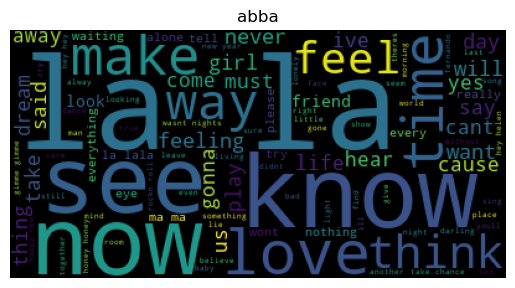

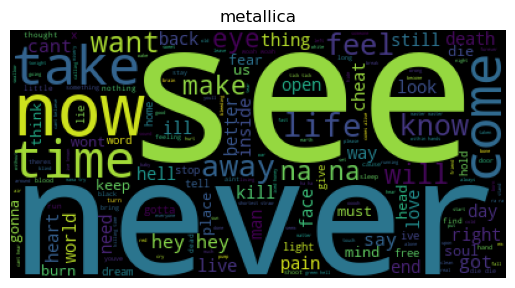

In [21]:
def word_cloud(artist_words, artist_names):
    '''
        Parameters
        ----------
        artist_words : nested list 
            This is a nested list of the all the words each artist says 
            
        '''
    
    cloud = wc.WordCloud() 
    
    # iterates through the length of the artist_words dictionary, 
    # the length is the number of artists
    
    for i in range(len(artist_words)):  
        # generates the word cloud
        artist_cloud = cloud.generate(" ".join(artist_words[i]))
        plt.axis("off")
        plt.title(artist_names[i])
        plt.imshow(artist_cloud)
        plt.show()

word_cloud(artist_words, artist_names)



ii) Plotting sentiment scores in a scatterplot

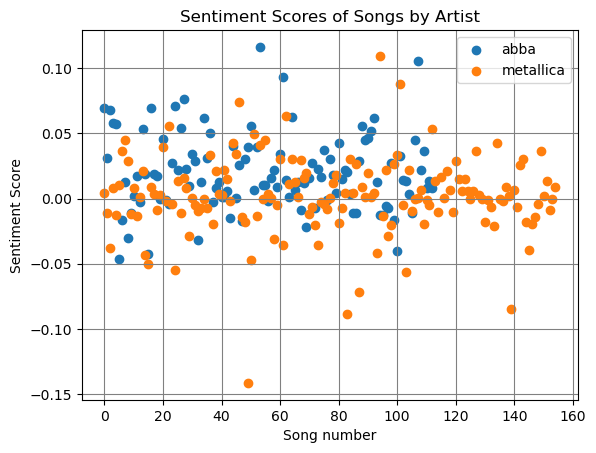

In [12]:
def plot_sentiment_scatter(artist_names, merged_artist):
    '''
        Parameters
        ----------
        artist_names, merged_artist : a list of artist names from user input, 
        merged_artist is a  merged dataframe of the artists cleaned text, sentiment scores 
        and richness scores. 
            
        Returns
        -------
        common_words: list
            A list of common words each artist 
        '''
    for names in artist_names:
        # seperates out the individual data frames 
        individual_df = merged_artist[merged_artist["artist"]== names]
        # plots sentiment scores on graph, using the index as x values and sentiment scores as y values
        plt.scatter(range(len(individual_df["sentiment_score"])), individual_df["sentiment_score"], label= names)
        
        # sets lables, legend and grid
        plt.xlabel("Song number")
        plt.ylabel("Sentiment Score")
        plt.title("Sentiment Scores of Songs by Artist")
        plt.legend()
        plt.grid(color = "grey")
plot_sentiment_scatter(artist_names, merged_artist)


iii) Creating a heat map to show word overlap between artists

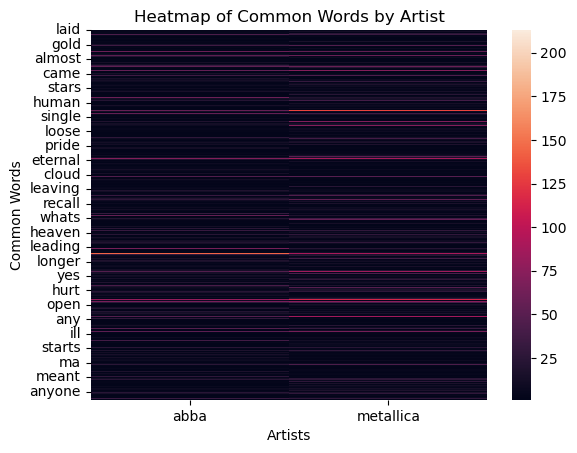

In [13]:
def heatmap(frequency_df, common_words):
    '''
        Parameters
        ----------
        frequency_df: dataframe with the total word frequencies for each artist 
            
        '''
    # uses the frequency dataframe and common words from previous function to create a 
    # new dataframe that contains the word frequencies of common words said by each artist
    common_df = frequency_df[common_words]
    
    # uses seaborn to create correlation matrix heatmap
    # .transpose() used to switch rows and columns 
    common_df = common_df.transpose()
    sns.heatmap(common_df)
    plt.xlabel("Artists")
    plt.ylabel("Common Words")
    plt.title("Heatmap of Common Words by Artist")
    
# calls the function
heatmap(frequency_df,common_words)

      
    

## Part 4- Generating text

**Implement a text generator that allows the user to specify the number of n-grams
and generate two new songs based on the lyrics of the specified artists**

In [14]:
ngrams_list = []
# this function allows the user to input the number of ngrams they want in each sentence
# and creates a nested list with them
def ngrams_generator(artist_words, n):
    '''
        Parameters
        ----------
        artist_words, n : artist_words is a nested list of all the words each artist says. 
        n is an int which is the number of n-grams the user specifies 
            
        Returns
        -------
        ngrams_list: nested list
            Contains a nested list with each artists words converted to the specified
            pattern of ngrams 
        '''
    for artist_song in artist_words:
        # uses zip to create n_gram
        ngrams = zip(*[artist_song[i:] for i in range(n)])
        # append ngrams into new_song
        ngrams_list.append([" ".join(ngram) for ngram in ngrams])
        
    return ngrams_list

# asks user to input number of n-grams and converts input to int
user_ngram = int(input("Please specify the number of n-grams you would like to generate two new songs "))
ngrams_list = ngrams_generator(artist_words, user_ngram)
print(ngrams_list)

Please specify the number of n-grams you would like to generate two new songs 3
[['look her face', 'her face wonderful', 'face wonderful face', 'wonderful face means', 'face means something', 'means something special', 'something special look', 'special look way', 'look way smiles', 'way smiles when', 'smiles when sees', 'when sees how', 'sees how lucky', 'how lucky fellow', 'lucky fellow shes', 'fellow shes kind', 'shes kind girl', 'kind girl makes', 'girl makes feel', 'makes feel fine', 'feel fine who', 'fine who could', 'who could ever', 'could ever believe', 'ever believe could', 'believe could mine', 'could mine shes', 'mine shes kind', 'shes kind girl', 'kind girl without', 'girl without her', 'without her blue', 'her blue ever', 'blue ever leaves', 'ever leaves could', 'leaves could could', 'could could when', 'could when walk', 'when walk park', 'walk park holds', 'park holds squeezes', 'holds squeezes hand', 'squeezes hand walking', 'hand walking hours', 'walking hours talking

In [15]:
# https://docs.python.org/3/library/random.html
# learned how to use parameters for random.choices, extension from lab

# this also allows the user to specify how long they want the new song to be
length = int(input("How many sentences long do you want the songs to be? "))
new_songs = []

# function to create new song
def create_new_song(ngrams_list):
    '''
    Parameters
    ----------
    ngrams_list: nested list
        Contains a nested list with each artists words converted to the specified
        pattern of ngrams 
            
    Returns
    -------
    new_song: nested list
        Contains a new generated song for each artist in a nested list  
    '''
    
    # the current sentences are randomly chosen from the list, and k is set
    # as the length which allowed the user to pick how many sentences to make the new song
    new_songs = [random.choices(song, k=length) for song in ngrams_list]
        
    return new_songs

# calls the function
new_songs = create_new_song(ngrams_list)
new_songs
   

How many sentences long do you want the songs to be? 10


[['here stay will',
  'jeanie fine jeanie',
  'whats good anyway',
  's when gone',
  'love makes sad',
  'again sad lose',
  'know belong still',
  'sun rainy weather',
  'youll certain when',
  'fire sweet devotions'],
 ['went mollys chamber',
  'flowing back into',
  'own coffin struggle',
  'from throne drink',
  'comes alive comes',
  'wheres crown king',
  'eternity save earth',
  'sweet lovely death',
  'hit curse curse',
  'feel closing pressure']]

## Part 5- Reflecting on the process

**Write a reflection on your experience working on this project. Discuss the challenges
you encountered during the development of the application, the solutions you
implemented, and the lessons you learned from the project. Reflect on the
effectiveness of the techniques used and propose potential improvements for future
iterations**

My experience working on this project was overall good. One of the biggest challenges I encountered was figuring out how to convert the csv file into a usable data structure that could be applied to all of my individual functions to make the code modular and efficent. This was because the application wanted analysis by artist, while all the data was organized by song, and there was non-numerical data which made it more challenging to aggregate by. The solution to this was to extract the different pieces of data I needed from the merged_artist dataframe, and pass different required data into my functions to analyze and run code on it. For example, sometimes I would pass the whole dataframe whereas other times it would be a list of all combined words merged from the "cleaned_text" column. The reason I created these different data structures at the beginning of my code was because I did not want to go through the process of extracting the needed data from the dataframe multiple times throughout my code for each function. Instead I thought it would be more efficent to just pass the data I needed into my functions. One lesson I learned from this project was how to create usable and efficent data structures to be used throughout my code. I believe this technique was effective, but a potential improvement for future iterations could be not having quite so many data structures being passed in when they contain some data overlap. I believe there could have been a more efficent way to do this if I could organize my data differently.

## Part 6- Going above and beyond

**You are encouraged to explore your data beyond the scope of the project brief and
uncover hidden information. This could involve various analyses and visualisations
that go beyond the provided tasks.**

i) Create a boxplot for the chosen artists sentiment and richness scores

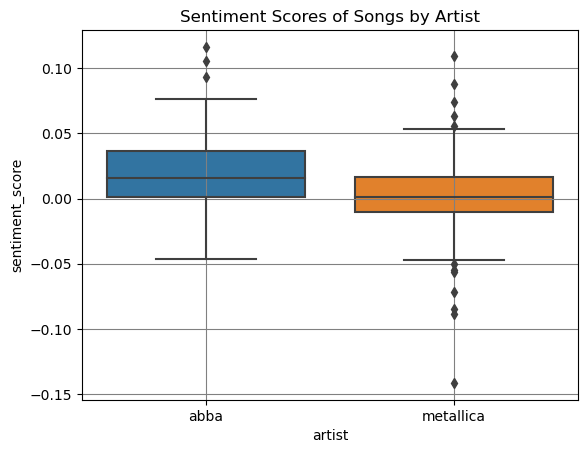

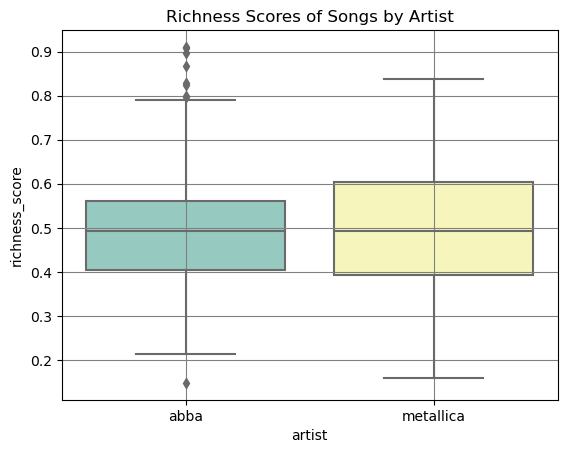

In [16]:
# Display boxplot of chosen artists richness and sentiment scores 
def plot_graph(merged_artist):
    '''
        Parameters
        ----------
        merged_artist : merged dataframe of the artists cleaned text, sentiment scores 
        and richness scores. 
             
    '''
    # uses seaborn boxplot function to access dataframe and plot the artist and sentiment score
    sns.boxplot(x = "artist", y = "sentiment_score", data = merged_artist)
    # plot lables and grid 
    plt.title("Sentiment Scores of Songs by Artist")
    plt.grid(color = "grey") 
    plt.show()
    
    # uses seaborn boxplot function to access dataframe and plot the artist and richness score
    sns.boxplot(x = "artist", y = "richness_score", data = merged_artist, palette = "Set3")
    # plot lables and grid 
    plt.title("Richness Scores of Songs by Artist")
    plt.grid(color = "grey") 
    plt.show()
        
# calls plot_graph function
plot_graph(merged_artist)

ii) Create a violin plot for each artists sentiment and richness scores

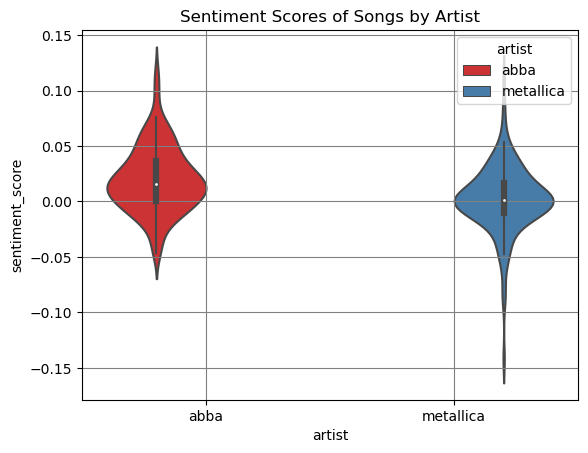

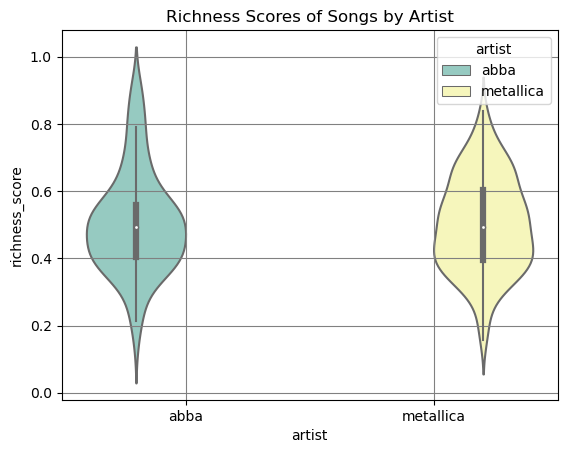

In [17]:
# this function plots violin plots for each artist by sentiment score and richness score
def plot_violin(merged_artist):
    '''
        Parameters
        ----------
        merged_artist : merged dataframe of the artists cleaned text, sentiment scores 
        and richness scores. 
             
    '''
    # uses seaborn violinplot function to access dataframe and plot the artist and sentiment score
    sns.violinplot(x = "artist", y = "sentiment_score", data = merged_artist,palette = "Set1", hue = "artist")
    plt.title("Sentiment Scores of Songs by Artist")
    plt.grid(color = "grey") 
    plt.show()
    
    # uses seaborn violinplot function to access dataframe and plot the artist and richness score
    sns.violinplot(x = "artist", y = "richness_score", data = merged_artist, palette = "Set3", hue = "artist")
    plt.title("Richness Scores of Songs by Artist")
    plt.grid(color = "grey") 
    plt.show()
    
plot_violin(merged_artist)

iii) Create a linear regression of the sentiment and richness score for each artist 
to see the correlation between the two variables

The R-squared value is 5.346322130961312e-05


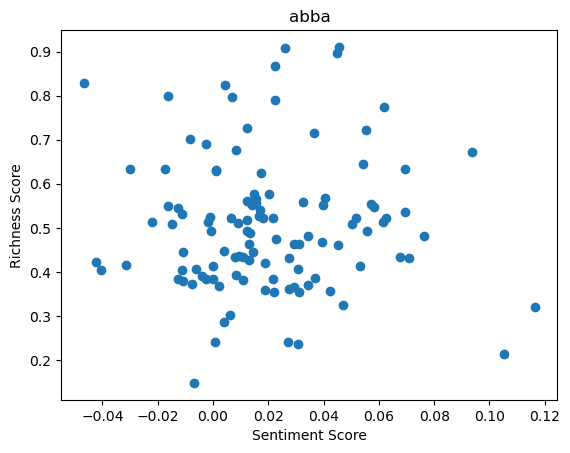

The R-squared value is 0.00022443354957479844


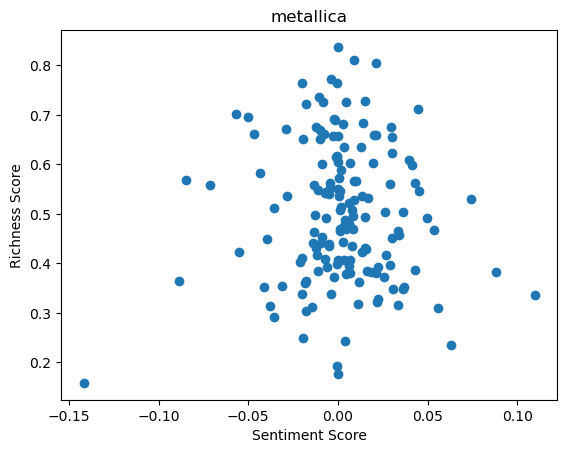

In [18]:
# linear regression of sentiment/richness score by artist

# plots scatter plot and determines r-squared value to determine how related sentiment 
# score and richness score are for each artust

def scatterplot(merged_artist, artist_names):
    '''
        Parameters
        ----------
        artist_names, merged_artist : a list of artist names from user input, 
        merged_artist is a  merged dataframe of the artists cleaned text, sentiment scores 
        and richness scores.  
        '''
    # seperates data frame by artist
    df_list = [merged_artist[merged_artist["artist"]== name] for name in artist_names]
    
    lr = LinearRegression()
    
    # iterates through each dataframe for individual artist in list
    for df in df_list:
        
        # sets x as the sentiment score and y as the richness score
        x = df[["sentiment_score"]]
        y = df[["richness_score"]]
        # fits the data
        lr.fit(x,y)
        # calculates the r^2 value
        print("The R-squared value is", lr.score(x,y))
        
        # plots scatter plot
        plt.scatter(x,y)
        plt.xlabel("Sentiment Score")
        plt.ylabel("Richness Score")
        plt.title(df["artist"].values[0])
        plt.show()
        
scatterplot(merged_artist, artist_names)